In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark

import os
import functools as reduce
from pyspark.context import SparkContext
from pyspark.sql import DataFrame, SQLContext, SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

conf = pyspark.SparkConf().setAppName('Regularization').setMaster('local')
sc = pyspark.SparkContext(conf = conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [2]:
spark

In [3]:
from sklearn.datasets import load_diabetes
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Loading the dataset and converting it into spark dataframe
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["y"] = diabetes.target
sdf = spark.createDataFrame(df)

assembler = VectorAssembler(inputCols=[col for col in sdf.columns if col != "y"],
                           outputCol="features")
dataset = assembler.transform(sdf)
dataset.show(5)

+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+--------------------+
|                 age|               sex|                bmi|                  bp|                  s1|                 s2|                 s3|                  s4|                 s5|                 s6|    y|            features|
+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+--------------------+
|  0.0380759064334241|0.0506801187398187| 0.0616962065186885|  0.0218723549949558| -0.0442234984244464|-0.0348207628376986|-0.0434008456520269|-0.00259226199818282| 0.0199084208763183|-0.0176461251598052|151.0|[0.03807590643342...|
|-0.00188201652779104|-0.044641636506989|-0.0514740612388061| -0.0263278

In [5]:
# Specifying the random seed so that train and test set always have the same set of rows respectively
np.random.seed(0)

In [6]:
train, test = dataset.randomSplit([0.5, 0.5], 25)
lr = LinearRegression(featuresCol="features", labelCol="y")
model = lr.fit(train)

# Evaluating on train data
summary_train = model.evaluate(train)
print("R2 (training): ", summary_train.r2)

# Evaluating on test data
summary_test = model.evaluate(test)
print("R2 (testing): ", summary_test.r2)

R2 (training):  0.4874503973681076
R2 (testing):  0.5303894499393103


In [7]:
# Now increasing the training fraction
p_train = [0.6, 0.7, 0.7, 0.9]
train_r2 = []
test_r2 = []

for p in p_train:
    train, test = dataset.randomSplit([p, 1-p], 25)
    lr = LinearRegression(featuresCol="features", labelCol="y")
    model = lr.fit(train)

    # Evaluating on train data
    summary_train = model.evaluate(train)
    train_r2.append(summary_train.r2)
    
    # Evaluating on test data
    summary_test = model.evaluate(test)
    test_r2.append(summary_test.r2)

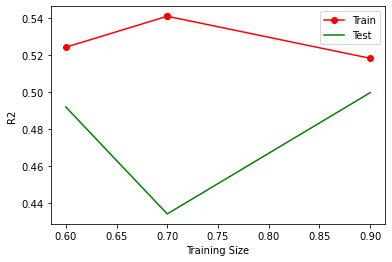

In [8]:
# Plotting
plt.plot(p_train, train_r2, "ro-", label = "Train")
plt.plot(p_train, test_r2, "g", label = "Test")
plt.xlabel("Training Size")
plt.ylabel("R2")
plt.legend()